# Intro to Argovis' Grid API - EOF analysis example - Jacopo Sala

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [13]:
import math
import numpy as np
from datetime import datetime, timedelta
import scipy.io
import xarray as xr
API_KEY=''

import pandas as pd
import numpy.matlib 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests
from calendar import monthrange
import pickle as pkl
import sys
import statistics
import cartopy.crs as ccrs
import numpy.linalg as LA
import timeit
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
from scipy import signal
from matplotlib.gridspec import GridSpec


## Downloading Gridded Data

Argovis offers gridded data at its `/grids` endpoint. Available query string parameters are:

 - `gridName` (mandatory, one of rgTempTotal, rgPsalTotal, ohc): name of gridded product to search.
 - `startDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (mandatory, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `presRange` (optional, format minimum_pressure,maximum_pressure): pressure window to filter for.

As noted, `gridName`, `startDate`, `endDate` and `polygon` are all required for downloading gridded data, but we can get just the metadata record that describes some high-level information about each grid by providing only the `gridName` parameter:


In [14]:
params = {
  "gridName": 'rgTempTotal',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())


{'_id': 'rgTempTotal', 'units': 'degree celcius (ITS-90)', 'levels': [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 182.5, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 462.5, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1412.5, 1500, 1600, 1700, 1800, 1900, 1975], 'date_added': '2022-04-27T23:07:27.943Z', 'lonrange': [-179.5, 179.5], 'latrange': [-64.5, 79.5], 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'], 'loncell': 1, 'latcell': 1}


We see information about the Roemmich-Gilson Argo climatology, like what pressure levels are present, what the minimum and maximum of latitude, longitude and time is in the grid, and soforth.

Let's try a simple request to download a piece of data from this climatology, a 10 degree box over the North Atlantic from the first quarter of 2012:

In [16]:
params = {
  "gridName": 'ohc',
  "startDate": '2010-01-01T00:00:00Z',
  "endDate": '2019-01-01T00:00:00Z',
#   "polygon": '[[-170, -5], [-170, 5], [-160, 5], [-160, -5], [-170, -5]]'
  "polygon": '[[130, -10], [130, 10], [-80, 10], [-80, -10], [130, -10]]'
#   "polygon": '[[-170, -10], [-170, 10], [170, 10], [170, -10], [-170, -10]]'
}

# [[lonmin,latmin],[lonmin,latmax],[lonmax,latmax],[lonmax,latmin],[lonmin,latmin]]

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata = r.json()

In [4]:
# params = {
#   "gridName": 'rgTempTotal',
#   "startDate": '2012-01-01T00:00:00Z',
#   "endDate": '2013-01-01T00:00:00Z',
#   "polygon": '[[-66.621094,42.163403],[-71.367188,40.580585],[-74.003906,37.439974],[-75.058594,35.029996],[-79.453125,32.249974],[-80.15625,29.993002],[-78.75,23.725012],[-73.828125,21.289374],[-70.3125,20.797201],[-67.5,19.47695],[-64.160156,19.47695],[-66.621094,42.163403]]'
# }

# r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
# rgdata = r.json()

Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

The first object in a request to `/grids` is always the appropriate *metadata record* for the grid, the same as what you got from `/grids?gridName=rgTempTotal` above. We automatically include it at the front of the full data requests as it is necessary for interpreting that data, as we'll see immediately below.

All the records returned by `/grids` after the first specify the actual data we wanted; let's have a look at one of them:

By default, Argovis returns gridded data in a *profile-like* structure: this record, located in space by its `g` key (for geolocation) and time by its `t` key, contains the grid points for all corresponding depths in its `d` (for data) key. To interpret the list of numbers, compare it entry-by-entry to the `levels` key in the metadata record; for example, the two records printed above indicate that the temperature at these coordinates and 10 dbar depth is 25.118999.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [5]:
def xargrid(grid):
    # given the json response <grid> of a request to /grids,
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    pres = []
    meas = []
    for p in grid[1:]:
        for i, e in enumerate(p['d']):
            if p['g']['coordinates'][0]<0:
                lon.append(p['g']['coordinates'][0]+360)
            else:
                lon.append(p['g']['coordinates'][0])
            lat.append(p['g']['coordinates'][1])
            # convert a string to a date (zeros to check at the end of date)
            time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            meas.append(p['d'][i])
            pres.append(grid[0]['levels'][i])
            
    df = pd.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pres, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds0 = xargrid(rgdata)

In [6]:
# print('latitudes:',ds0['latitude'].data)
# print('longitudes:',ds0['longitude'].data)
# print('times:',ds0['time'].data)
# print('pressures:',ds0['pressure'].data)

In [7]:
# Cropped version of the ds
min_lon = 130
min_lat = -10
max_lon = 280
max_lat = 10
mask_lon = (ds0.longitude >= min_lon) & (ds0.longitude <= max_lon)
mask_lat = (ds0.latitude >= min_lat) & (ds0.latitude <= max_lat)
ds = ds0.where(mask_lon & mask_lat, drop=True)
# cropped_ds

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

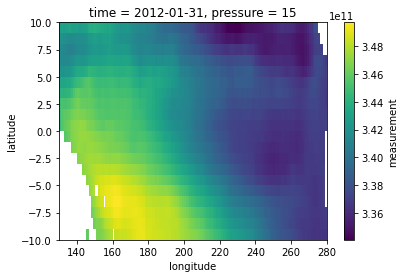

In [8]:
# Cropped version
gridmap = ds.loc[{"time":'2012-01-31T00:00:00.000Z'}] #, "pressure":2.5}]
gridmap['measurement'].plot()

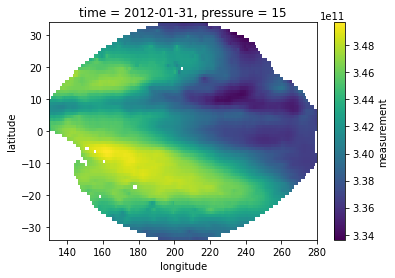

In [9]:
# Original version 
gridmap = ds0.loc[{"time":'2012-01-31T00:00:00.000Z'}] #, "pressure":2.5}]
gridmap['measurement'].plot()

## Area-Weighted Means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [ ]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [ ]:
dxr_aw = areaweighted_region_mean(dxr=ds)
print(dxr_aw.loc[{"time":'2012-01-31T00:00:00.000Z'}])#, "pressure":2.5}])
dxr_aw

In [ ]:
# Time series plot 
dxr_aw['measurement'].plot()

In [ ]:
OHC_anom.plot()

In [ ]:
OHC_anom = dxr_aw['measurement'] - np.mean(dxr_aw['measurement']) 



In [10]:
# El Nino 3.4 index region
lon_min = 190
lon_max = 240
lat_min = -5
lat_max = 5

mask_lon = (ds0.longitude >= lon_min) & (ds0.longitude <= lon_max)
mask_lat = (ds0.latitude >= lat_min) & (ds0.latitude <= lat_max)

nino34 = ds0.where(mask_lon & mask_lat, drop=True)

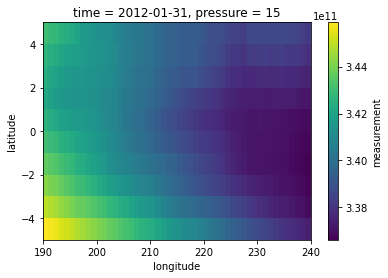

In [12]:
gridmap = nino34.loc[{"time":'2012-01-31T00:00:00.000Z'}]
gridmap['measurement'].plot()

## Prepare the data for the EOF analysis

In [ ]:
# Swap dimensions to match what the rest of the code has been built for
measurement = np.swapaxes(ds.measurement.values,0,2)
measurement = np.swapaxes(measurement,1,2)

In [ ]:
# Reshape as a 3D array
measurement_3d = measurement.reshape(measurement.shape[0],measurement.shape[1],measurement.shape[2])

In [ ]:
# Convert data into a xarray Dataarray
d_GCOS_temp_zint = xr.DataArray(
         data=measurement_3d,
        dims=["time", "lat", "lon", ],
        coords=dict(
            time=ds.time.values,
            lat=(["lat"], ds.latitude.values),
            lon=(["lon"], ds.longitude.values),
        ),
    attrs=dict(
        description="Ocean heat content.",
        units="J/m2",
    ),
    )

lat = d_GCOS_temp_zint['lat']
lon = d_GCOS_temp_zint['lon']
time = ds.time.values

print(f'd_GCOS_temp_zint: {type(d_GCOS_temp_zint), d_GCOS_temp_zint.shape}')
print(f'lat: {type(lat), lat.shape}')
print(f'lon: {type(lon), lon.shape}')
print(f'type of data - should be xarray DataArray: {type(d_GCOS_temp_zint)}') ## check that the data is Xarray

In [ ]:
#Shift the dataset by 180 degrees to get indices for Pacific basin to be monotonically increasing
dsshift=ds.roll(longitude=180,roll_coords=True)
#dsshift2=dsshift 
shiftedlon=dsshift['longitude'].values
shiftedlon[dsshift['longitude'].values<0]=dsshift['longitude'].values[dsshift['longitude'].values<0]+360

In [ ]:
## Cosine weighting following Hannachi et al. 2007 page 1123

d_GCOS_temp_zintwgt=d_GCOS_temp_zint*np.sqrt(np.cos(lat*np.pi/180))
print(f'shape of d_GCOS_temp_zintwgt: {np.shape(d_GCOS_temp_zintwgt)}')


In [ ]:
# Take anomalies - subtract the mean (keep by default)
d_GCOS_temp_zintanom=d_GCOS_temp_zintwgt-d_GCOS_temp_zint.mean('time');

# Remove the seasonal cycle (keep by default)
climo=d_GCOS_temp_zintanom.groupby('time.month').mean('time')
d_GCOS_temp_zintanom=d_GCOS_temp_zintanom.groupby('time.month')-climo
print(f'shape of TSwgtanom: {np.shape(d_GCOS_temp_zintanom)}')

# Remove the linear trend
time1=np.arange(1,len(time)+1,1)
print(np.shape(time1))
# calculate the slope a1
a1=np.dot(time1-time1.mean(),np.swapaxes(d_GCOS_temp_zintanom.values,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
print(np.shape(a1))
a1_broadcast=a1[None,:,:]*time1[:,None,None]
print(np.shape(a1_broadcast))
d_GCOS_temp_zintanom.values=d_GCOS_temp_zintanom.values-a1_broadcast;

# Standardize your data - divide by the standard deviation (keep by default)
d_GCOS_temp_zintanomstd=d_GCOS_temp_zintanom/(d_GCOS_temp_zintanom.std('time'));

In [ ]:
### At the end of this first step you want two matrices ready for EOF analysis
### Y_stand = standardized data, dimensioned (time,location)
### Y = original data, dimensioned (time,location)
### everything below in the code assumes that you have Y_stand, Y defined as above

#flatten the lat,lon in the array so that you have an array dimensioned (time,location)
a,b,c=np.shape(d_GCOS_temp_zintanom.values)  ## have axis sizes for later (a, b, c)
Y_stand=d_GCOS_temp_zintanomstd.values.reshape(a,b*c);
Y=d_GCOS_temp_zintanom.values.reshape(a,b*c);  ## just the anomaly - you'll need this later for step 5(physical units)
print(a,b,c)
print(np.shape(Y_stand))
print(np.shape(Y))

In [ ]:
#plot the standardized and original time series for one location -- Look at your data!!
y_chosen = np.shape(time)

f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0]);
plt.plot(Y_stand[:,y_chosen],label='standardized',color='black');
plt.legend();
plt.xlabel('Months')
plt.subplot(gs[0,1]);
plt.plot(d_GCOS_temp_zint.values.reshape(a,b*c)[:,y_chosen],label='original',color='red');
# plt.ylim([3.15E11,3.28E11])
plt.legend();
plt.xlabel('Months')


In [ ]:
# Set NaNs to zero
Y_stand = np.nan_to_num(Y_stand)

## Caclulate the EOFs (using two different approaches)

In [ ]:
### Calculate the EOFs -- Using eigenanalysis of the covariance matrix (the np.linalg.eig method)

#calculate covariance matrix
C = 1./np.size(Y_stand,axis = 0)*np.dot(np.transpose(Y_stand),Y_stand)
print(np.shape(Y_stand))
print(np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method - will take a couple of minutes
start_time = timeit.default_timer()
lam, E = LA.eig(C)
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA eigenvalue method: ',elapsed, 'seconds')

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

In [ ]:
### Calculate the EOFs -- Using Singular Value Decomposition (SVD) (the np.linalg SVD method)
start_time = timeit.default_timer()
u,s,v=LA.svd(Y_stand) 
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA SVD method: ',elapsed,' seconds')

## Eigenvalues

In [ ]:
### Plot the eigenvalues from both methods including errors bars following North et al. 1982.

# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))

f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,100])
plt.xlim([0.5,10])
plt.ylabel('Percent Variance Explained')
plt.xlabel('Eigenvalue')
plt.legend()

Nstar = np.size(Y_stand,axis = 0) ## assume all data is independent (not a great assumption, how do we do better?)
print(Nstar)
###  could for example - find the effective sample size using the average of all data
###  Caution: Use the data that went into the EOF analysis for this calculation, not the original data...
tseries=np.nanmean(np.nanmean(d_GCOS_temp_zintanomstd,axis=2),axis=1)  ## warning from land nans, ignore it!
print(np.shape(tseries))
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
N=len(tseries)         ## calculate the length of the timeseries
lag=1
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean
alpha=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print('lag1 autocorrelation from np.correlate:',round(alpha[0],3))
### Calculate the effective sample size (Nstar) for this data
### To estimate the number of independent samples
Nstar=np.round((1-alpha)/(1+alpha)*N,0)
print('Nstar: ',Nstar)
eb = pve*np.sqrt(2./Nstar)  ## North 1982
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black');


## Plot the first EOF

In [ ]:
### Plot the first EOF pattern and PC timeseries 

# select an EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1: {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
##print(np.shape(v),np.shape(s),np.shape(u))  ## uncomment to check the shapes of SVD output
e1_svd = (v[eof_num-1,:])
print(f'shape of e1_svd {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape of z1_svd: {np.shape(z1_svd)}')

In [ ]:
efirst = e1
zfirst = z1
efirst_svd = e1_svd
zfirst_svd = z1_svd

In [ ]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,e1.reshape(b,c),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF 1 (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('Principal Component (amplitude) from eigenanalysis')
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,np.real(e1_svd).reshape(b,c),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF 1 (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('Principal Component (amplitude) from SVD');

In [ ]:
### Regress the data (unweighted data if applicable) onto standardize values of the PC 
### for eof_num above
      
# calculate d (EOF in physical units) for plotting
## d1 is in physical units (in this case degrees)  and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y) 
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))

### Make a plot of the EOF in physical units and associated PC
f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,d1plot,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Ocean heat content (J/m2) change when z1 increases by 1 $\sigma$')
plt.title('EOF1 in physical units')
plt.subplot(gs[0,1])
plt.plot(time,z1)
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.ylabel('amplitude of variation in standardized units');
plt.title('PC1 in standardized units');

## Plot the second EOF

In [ ]:
### Plot the second EOF pattern and PC timeseries 

# select an EOF
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1: {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
##print(np.shape(v),np.shape(s),np.shape(u))  ## uncomment to check the shapes of SVD output
e1_svd = (v[eof_num-1,:])
print(f'shape of e1_svd {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape of z1_svd: {np.shape(z1_svd)}')

In [ ]:
esecond = e1
zsecond = z1
esecond_svd = e1_svd
zsecond_svd = z1_svd

In [ ]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,e1.reshape(b,c),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF 2 (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.plot(time,(z1))
plt.title('Principal Component (amplitude) from eigenanalysis')
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,np.real(e1_svd).reshape(b,c),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF 2 (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.plot(time,(z1_svd))
plt.title('Principal Component (amplitude) from SVD');

In [ ]:
### Regress the data (unweighted data if applicable) onto standardize values of the PC 
### for eof_num above

# calculate d (EOF in physical units) for plotting
## d1 is in physical units (in this case degrees)  and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot

### Make a plot of the EOF in physical units and associated PC
f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,d1plot,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Ocean heat content (J/m2) change when z1 increases by 1 $\sigma$')
plt.title('EOF2 in physical units')
plt.subplot(gs[0,1])
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units')
plt.title('PC2 in standardized units')


In [ ]:
efirst = e1
zfirst = z1
efirst_svd = e1_svd
zfirst_svd = z1_svd

In [ ]:
esecond = e1
zsecond = z1
esecond_svd = e1_svd
zsecond_svd = z1_svd

In [ ]:
ediff = efirst - esecond
zdiff = zfirst - zsecond
ediff_svd = efirst_svd - esecond_svd
zdiff_svd = zfirst_svd - zsecond_svd